# Schooling in Xenopus tadpoles

Playground to troubleshoot analysis procedures.

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial

In [143]:
def preProcess(d):
    d.columns = ['Tad']+[d.columns[i].replace(' ','') for i in range(1,len(d.columns))] # Remove spaces in column names
    d.insert(1, 'Frame', 0)
    
    for i in range(1,d.shape[0]):
        if d.loc[i,'Tad']<d.loc[i-1,'Tad']:
            d.loc[i,'Frame'] = d.loc[i-1,'Frame']+1
        else:
            d.loc[i,'Frame'] = d.loc[i-1,'Frame']
    # Note that d['Frame'][i] wouldn't have worked because of chain slicing: applying 2nd slice after the 1st would
    # have created a copy of the dataframe, and so wouldn't have transformed the original dataframe
    d.Frame = d.Frame.astype(int) # Not sure why it becomes float, but I don't like it
            
    return d

d = pd.read_csv('data/control.csv')
d = preProcess(d)
print(d[:5])

   Tad  Frame  Area  Min  Min  Max      X       Y
0    1      0     0  215  215  215  7.391  14.783
1    2      0     0  128  128  128  7.232  14.643
2    3      0     0  239  239  239  8.850  14.623
3    4      0     0  156  156  156  8.670  14.443
4    5      0     0  236  236  236  7.751  12.426


Standard ImageJ format. X and Y are coordinates; every odd row is a tadpole head; every odd row is a tail. The first row goes from 1 to 2n (where n is the number of tadpoles in each frame), then starts anew. We manually add a frame counter.

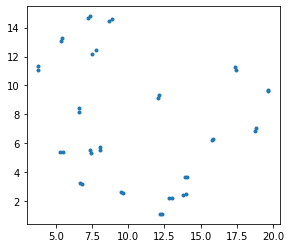

In [144]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(d.loc[d.Frame==0,'X'],d.loc[d.Frame==0,'Y'],'.');
ax.set_aspect('equal')

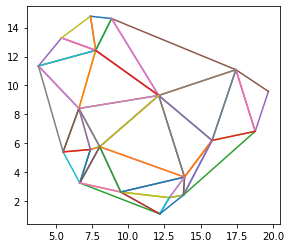

In [145]:
def extractDistances(d,iFrame):
    xy = d.loc[d.Frame==iFrame,['X','Y']].to_numpy()
    xy = xy[0::2,:] # Only leave heads, remove tails
    tri = scipy.spatial.Delaunay(xy,qhull_options="QJ").simplices # Help says that this "QJ" is needed if you want to
                                                                  # have all tadpoles in the output (even lonely ones)
    listOfPairs = [] # Array of tuples
    for i in range(tri.shape[0]):
        t = [tuple(tri[i,[0,1]]) , tuple(tri[i,[1,2]]) , tuple(tri[i,[2,0]])]
        for p in t:
            if not p in listOfPairs:
                listOfPairs += [p]
    return [(xy[p,0] , xy[p,1]) for p in listOfPairs]


listOfPoints = extractDistances(d,0)
fig = plt.figure()
ax = fig.add_subplot(111)
for p in listOfPoints:
    ax.plot(p[0],p[1])
ax.set_aspect('equal')